# 1: dataset familiarization:
In this step we run a simple code that extracts the height and width of the images from the JSON file and looks for anomalies in the dataset to ensure that the data is valid.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import json

file_name = "/content/drive/MyDrive/Kvasir-SEG/kavsir_bboxes.json"
dataset_entries = []
def read_json_file(file_name):
    try:
        with open(file_name, 'r') as file:
            data = json.load(file)
            return data
    except FileNotFoundError:
        print("File not found.")
        return None
    except json.JSONDecodeError:
        print("Error decoding JSON.")
        return None

def extract_height_width(json_data):
    height_list = []
    width_list = []
    if isinstance(json_data, dict):
        global dataset_entries
        dataset_entries = list(json_data.keys())
        for item in json_data.values():
            if isinstance(item, dict) and 'height' in item and 'width' in item:
                height_list.append(item['height'])
                width_list.append(item['width'])
            else:
                print("Invalid JSON structure. Missing 'height' or 'width' attribute.")
    else:
        print("Invalid JSON format. Expected a list at the top level.")
    return [height_list, width_list]

json_data = read_json_file(file_name)
if json_data:
    variables_list = extract_height_width(json_data)
    print("Height range:")
    print(min(variables_list[0]), max(variables_list[0]))
    print("Width range:")
    print(min(variables_list[1]), max(variables_list[1]))
    print("size ", len(variables_list[0]))
    print("first name ", dataset_entries[0])

Height range:
352 1072
Width range:
332 1920
size  1000
first name  cju0qkwl35piu0993l0dewei2


# 2: image resizing and normalization:
Having read about models like ResNet and VGG, I decided to resize each image to 256*256 square images, and normalize each pixel value in a range of 0 to 255. Our mask is a simple black and white image, so I just normalize that to a boolean range of True or False.

Streaming output truncated to the last 5000 lines.

 34%|███▎      | 336/1000 [03:06<07:00,  1.58it/s]


 34%|███▎      | 337/1000 [03:07<06:50,  1.61it/s]


 34%|███▍      | 338/1000 [03:07<06:38,  1.66it/s]


 34%|███▍      | 339/1000 [03:08<06:40,  1.65it/s]


 34%|███▍      | 340/1000 [03:09<06:36,  1.66it/s]


 34%|███▍      | 341/1000 [03:09<06:30,  1.69it/s]


 34%|███▍      | 342/1000 [03:10<06:24,  1.71it/s]


 34%|███▍      | 343/1000 [03:10<06:59,  1.57it/s]


 34%|███▍      | 344/1000 [03:11<06:47,  1.61it/s]


 34%|███▍      | 345/1000 [03:12<06:44,  1.62it/s]


 35%|███▍      | 346/1000 [03:12<07:16,  1.50it/s]


 35%|███▍      | 347/1000 [03:13<08:09,  1.34it/s]


 35%|███▍      | 348/1000 [03:14<07:42,  1.41it/s]


 35%|███▍      | 349/1000 [03:15<07:17,  1.49it/s]


 35%|███▌      | 350/1000 [03:15<06:58,  1.55it/s]


 35%|███▌      | 351/1000 [03:16<06:48,  1.59it/s]


 35%|███▌      | 352/1000 [03:16<06:46,  1.59it/s]


 35%|███▌      | 353/1000 [03:17<06:38,  1.62it

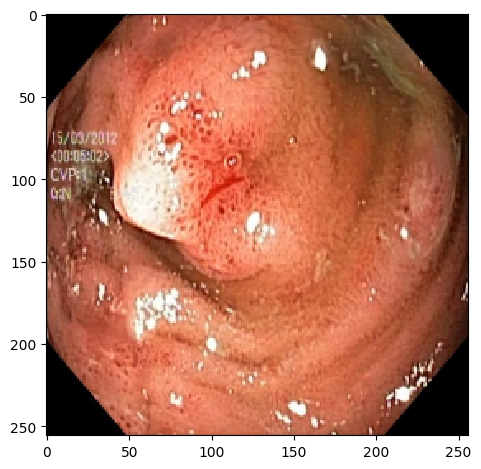

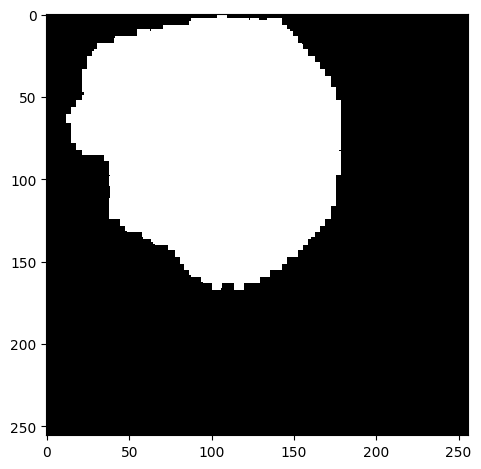

In [7]:
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import random
import math

np.random.seed = 42

def preprocess_image(image_path, target_size=(256, 256), imtype = 'COLOR'):
    # Read image
    if (imtype == 'COLOR'):
      image = imread(image_path)[:,:,:3]
    else:
      image = imread(image_path)[:,:,:1]

    # Resize image
    image = resize(image, target_size, mode='constant', preserve_range=True)

    # Convert image to float32
    if (imtype == 'COLOR'):
        image = image.astype(np.float32)
        # Normalize pixel values to [0, 1]
        image /= 255.0
    else:
        image = image.astype(bool)

    return image


preprocess_images = [preprocess_image("/content/drive/MyDrive/Kvasir-SEG/images/"+name+".jpg", imtype='COLOR') for name in tqdm(dataset_entries)]
preprocess_masks = [preprocess_image("/content/drive/MyDrive/Kvasir-SEG/masks/"+name+".jpg", imtype='GRAY') for name in tqdm(dataset_entries)]
images = np.array(preprocess_images)
masks = np.array(preprocess_masks)

imshow(images[0])
plt.show()
imshow(masks[0])
plt.show()

# 3: model implementation:
As recommened by the project, we use U-Net as opposed to Mask R-CNN. The reasons are simply two-fold:
   
1- U-Net has a simpler architecture with an encoder-decoder architecture with skip connections, as opposed to a mask prediction network, a region proposal network and a backbone CNN.  
  
2- U-Nets appear to be used more in use cases such as medical image segmentation or satellite image analysis. While Mask R-CNN is more useful in tasks that involve instance segmentation, where the goal is to detect and segment individual objects within an image such as object detection.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def u_net_model(input_shape):
    inputs = layers.Input(input_shape)
    #Downsampling
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)
    #the fucking bottleneck layer
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    #Upsampling
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.3)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3) # maybe 2?
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (256, 256, 3)
model = u_net_model(input_shape)
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
model.summary()


  0%|          | 3/1000 [22:12<123:00:25, 444.16s/it]
Exception ignored in: <function PluginV3.__del__ at 0x7e6650d13910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/imageio/core/v3_plugin_api.py", line 370, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py", line 128, in close
    self._request.finish()
  File "/usr/local/lib/python3.10/dist-packages/imageio/core/request.py", line 570, in finish
    self._file.close()
OSError: [Errno 107] Transport endpoint is not connected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

# 4: training:
here we train the model using the input date

Exception ignored in: <function _xla_gc_callback at 0x7e65d25735b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


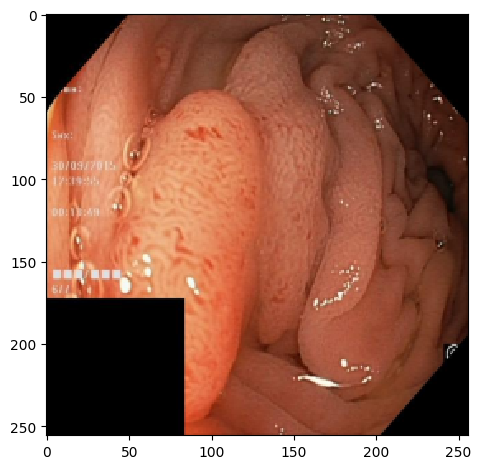

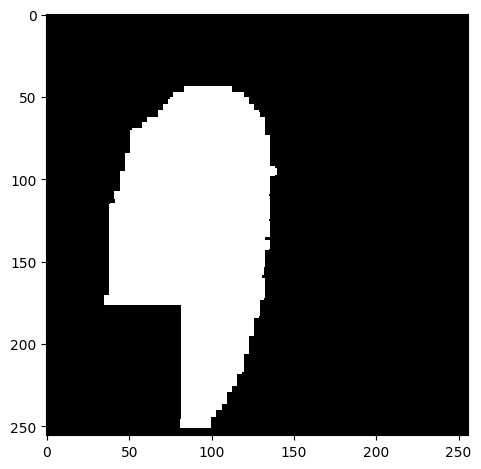

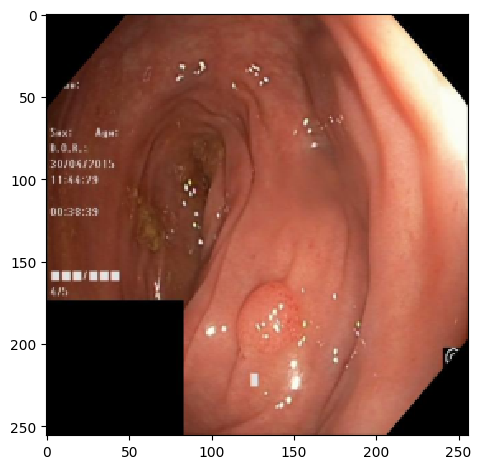

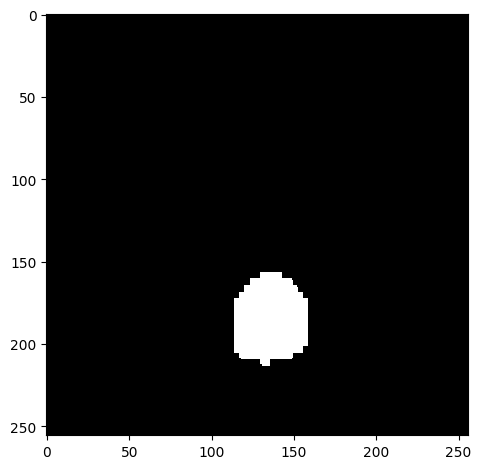

In [44]:
def split_data(inputdata, maskdata, split_ratio, randomseed):
    random.seed(randomseed)
    size = int(len(inputdata) * split_ratio)
    indices = random.sample(range(size), math.floor(split_ratio*size))
    train_images = np.array([inputdata[i] for i in indices], dtype=np.float32)
    train_masks = np.array([maskdata[i] for i in indices], dtype=bool)
    val_images = []
    val_masks = []
    for i in range(len(inputdata)):
        if i not in indices:
            val_images.append(inputdata[i])
            val_masks.append(maskdata[i])
    val_images = np.array(val_images, dtype=np.float32)
    val_masks = np.array(val_masks, dtype=np.float32)
    return train_images, train_masks, val_images, val_masks

train_images, train_masks, val_images, val_masks = split_data(preprocess_images, preprocess_masks, 0.9, 42)
imshow(train_images[0])
plt.show()
imshow(train_masks[0])
plt.show()
imshow(val_images[0])
plt.show()
imshow(val_masks[0])
plt.show()

In [10]:
from tensorflow.keras import callbacks

checkpointer = callbacks.ModelCheckpoint('model for polyp.h5', verbose=1, save_best_only = True)
callbacks = [callbacks.EarlyStopping(patience=20, monitor='val_loss'),
            callbacks.TensorBoard(log_dir="logs")]


results = model.fit(train_images, train_masks, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)



Epoch 1/100
46/46 [==============================] - 36s 381ms/step - loss: 0.5656 - accuracy: 0.8189 - val_loss: 0.4671 - val_accuracy: 0.8091
Epoch 2/100
46/46 [==============================] - 9s 187ms/step - loss: 0.4386 - accuracy: 0.8278 - val_loss: 0.4669 - val_accuracy: 0.8091
Epoch 3/100
46/46 [==============================] - 9s 189ms/step - loss: 0.4117 - accuracy: 0.8278 - val_loss: 0.4239 - val_accuracy: 0.8091
Epoch 4/100
46/46 [==============================] - 9s 190ms/step - loss: 0.4055 - accuracy: 0.8278 - val_loss: 0.4256 - val_accuracy: 0.8091
Epoch 5/100
46/46 [==============================] - 9s 191ms/step - loss: 0.3929 - accuracy: 0.8278 - val_loss: 0.4147 - val_accuracy: 0.8091
Epoch 6/100
46/46 [==============================] - 9s 189ms/step - loss: 0.3795 - accuracy: 0.8279 - val_loss: 0.4096 - val_accuracy: 0.8091
Epoch 7/100
46/46 [==============================] - 9s 192ms/step - loss: 0.3783 - accuracy: 0.8276 - val_loss: 0.3919 - val_accuracy: 0.809

In [11]:
def new_net_model(input_shape):
    inputs = layers.Input(input_shape)
    #Downsampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)
    #the fucking bottleneck layer
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    #Upsampling
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.3)(c6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3) # maybe 2?
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (256, 256, 3)
model2 = new_net_model(input_shape)
model2.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 32)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 32)         9248      ['dropout_9[0][0]']           
                                                                                            

In [13]:
from tensorflow.keras import callbacks

checkpointer = callbacks.ModelCheckpoint('model for polyp2.h5', verbose=1, save_best_only = True)
callbacks = [callbacks.EarlyStopping(patience=10, monitor='val_loss'),
            callbacks.TensorBoard(log_dir="logs")]


results2 = model2.fit(train_images, train_masks, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)


Epoch 1/100


  4%|▎         | 36/1000 [45:17<20:12:54, 75.49s/it]

 1/46 [..............................] - ETA: 16:21 - loss: 0.6176 - accuracy: 0.7278

46/46 [==============================] - 51s 650ms/step - loss: 0.5496 - accuracy: 0.8251 - val_loss: 0.5161 - val_accuracy: 0.8091
Epoch 2/100
46/46 [==============================] - 16s 350ms/step - loss: 0.4608 - accuracy: 0.8278 - val_loss: 0.4748 - val_accuracy: 0.8091
Epoch 3/100
46/46 [==============================] - 16s 347ms/step - loss: 0.4331 - accuracy: 0.8278 - val_loss: 0.4504 - val_accuracy: 0.8091
Epoch 4/100
46/46 [==============================] - 16s 348ms/step - loss: 0.4164 - accuracy: 0.8278 - val_loss: 0.4530 - val_accuracy: 0.8091
Epoch 5/100
46/46 [==============================] - 16s 350ms/step - loss: 0.4000 - accuracy: 0.8278 - val_loss: 0.4224 - val_accuracy: 0.8091
Epoch 6/100
46/46 [==============================] - 16s 356ms/step - loss: 0.3999 - accuracy: 0.8278 - val_loss: 0.4219 - val_accuracy: 0.8091
Epoch 7/100
46/46 [==============================] - 16s 356ms/step - loss: 0.3926 - accuracy: 0.8278 - val_loss: 0.4222 - val_accuracy: 0.8091
Epoc

In [14]:
def new_new_net_model(input_shape):
    inputs = layers.Input(input_shape)
    #Downsampling
    c0 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c0 = layers.Dropout(0.1)(c0)
    c0 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c0)
    p0 = layers.MaxPooling2D((2,2))(c0)

    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p0)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)
    #the fucking bottleneck layer
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    #Upsampling
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.3)(c6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3) # maybe 2?
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    u10 = layers.Conv2DTranspose(16, (2, 2), strides=(2,2), padding='same')(c9)
    u10 = layers.concatenate([u10, c0], axis=3) # maybe 2?
    c10 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = layers.Dropout(0.1)(c10)
    c10 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c10)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (256, 256, 3)
model3 = new_net_model(input_shape)
model3.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 32)         896       ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 32)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 32)         9248      ['dropout_18[0][0]']          
                                                                                            

In [15]:
from tensorflow.keras import callbacks

checkpointer = callbacks.ModelCheckpoint('model for polyp3.h5', verbose=1, save_best_only = True)
callbacks = [callbacks.EarlyStopping(patience=10, monitor='val_loss'),
            callbacks.TensorBoard(log_dir="logs")]


results3 = model3.fit(train_images, train_masks, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)


Epoch 1/100
46/46 [==============================] - 23s 358ms/step - loss: 0.5602 - accuracy: 0.8162 - val_loss: 0.4635 - val_accuracy: 0.8091
Epoch 2/100
46/46 [==============================] - 16s 357ms/step - loss: 0.4276 - accuracy: 0.8277 - val_loss: 0.4548 - val_accuracy: 0.8091
Epoch 3/100
46/46 [==============================] - 16s 357ms/step - loss: 0.4119 - accuracy: 0.8277 - val_loss: 0.4519 - val_accuracy: 0.8091
Epoch 4/100
46/46 [==============================] - 16s 354ms/step - loss: 0.3954 - accuracy: 0.8278 - val_loss: 0.4913 - val_accuracy: 0.8091
Epoch 5/100
46/46 [==============================] - 16s 345ms/step - loss: 0.3892 - accuracy: 0.8279 - val_loss: 0.4986 - val_accuracy: 0.8091
Epoch 6/100
46/46 [==============================] - 16s 345ms/step - loss: 0.3858 - accuracy: 0.8279 - val_loss: 0.5083 - val_accuracy: 0.8091
Epoch 7/100
46/46 [==============================] - 16s 346ms/step - loss: 0.3810 - accuracy: 0.8282 - val_loss: 0.4891 - val_accuracy:

# 5: validation
we test these 3 models on the val_images datatest with DICE score to see which one performs better and compare it with the paper.  
But first we start with accuracy:

In [16]:
test_loss, test_accuracy = model.evaluate(val_images, val_masks)
print("Model1 Test Loss:", test_loss)
print("Model1 Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model2.evaluate(val_images, val_masks)
print("Model2 Test Loss:", test_loss)
print("Model2 Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model3.evaluate(val_images, val_masks)
print("Model3 Test Loss:", test_loss)
print("Model3 Test Accuracy:", test_accuracy)


6/6 [==============================] - 8s 813ms/step - loss: 0.3160 - accuracy: 0.9253
Model1 Test Loss: 0.3160342276096344
Model1 Test Accuracy: 0.9253121614456177
6/6 [==============================] - 16s 2s/step - loss: 0.2583 - accuracy: 0.9151
Model2 Test Loss: 0.2583455443382263
Model2 Test Accuracy: 0.9151106476783752
6/6 [==============================] - 1s 130ms/step - loss: 0.2359 - accuracy: 0.9288
Model3 Test Loss: 0.23593959212303162
Model3 Test Accuracy: 0.9287948608398438


6/6 [==============================] - 0s 76ms/step


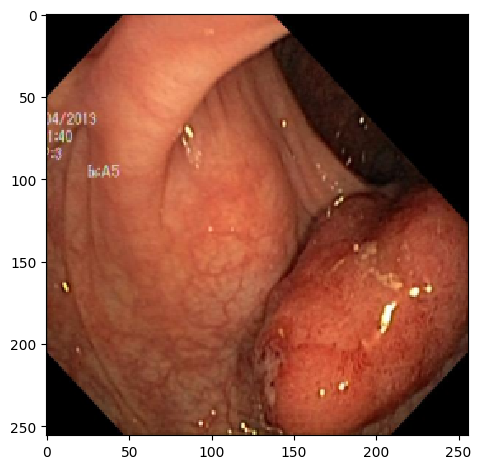

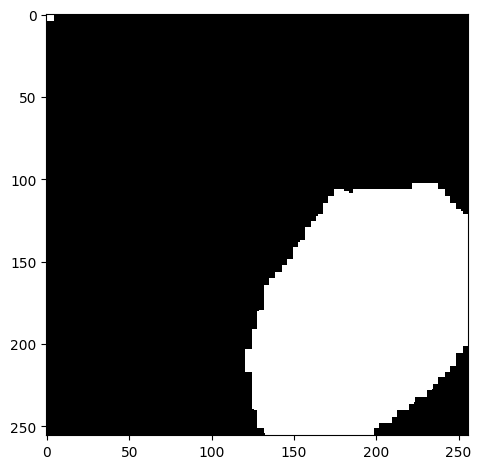

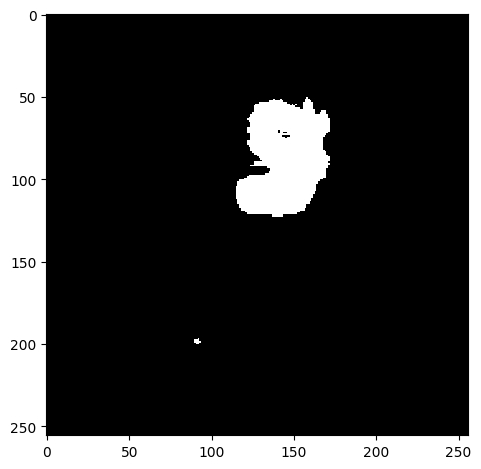

In [50]:
preds_val1 = model.predict(val_images, verbose=1)

preds_val_t1 = (preds_val1 > 0.5).astype(np.float32)

ix = 8
imshow(val_images[int(val_images.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(val_masks[int(val_masks.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t1[ix]))
plt.show()

6/6 [==============================] - 1s 127ms/step


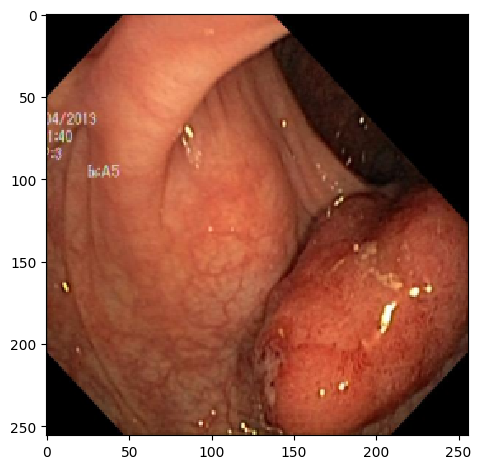

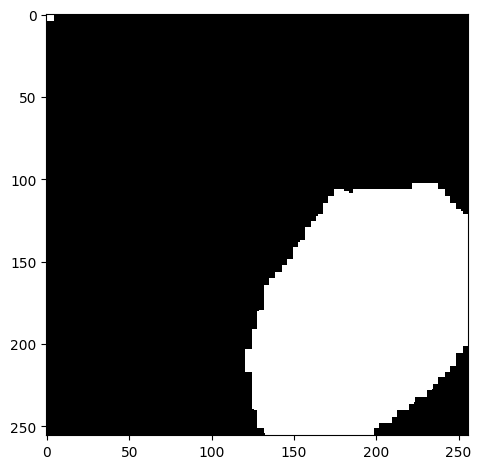

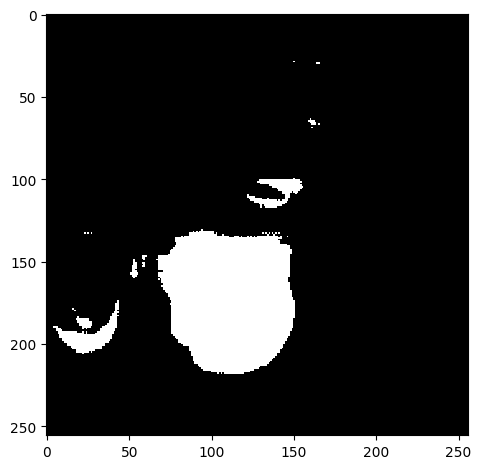

8


In [51]:
preds_val2 = model2.predict(val_images, verbose=1)

preds_val_t2 = (preds_val2 > 0.5).astype(np.float32)

ix = 8
imshow(val_images[int(val_images.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(val_masks[int(val_masks.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t2[ix]))
plt.show()
print(ix)

6/6 [==============================] - 1s 134ms/step


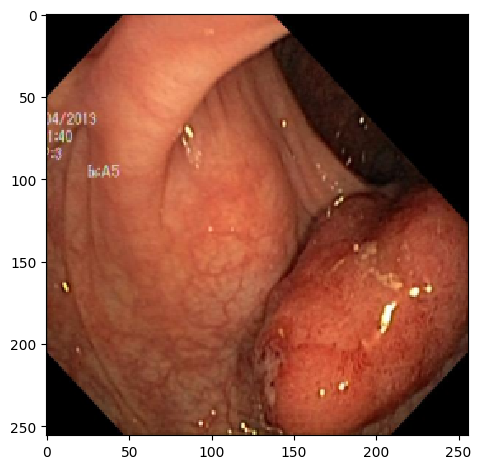

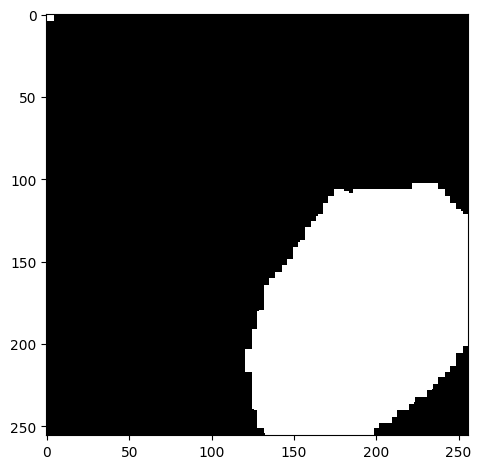

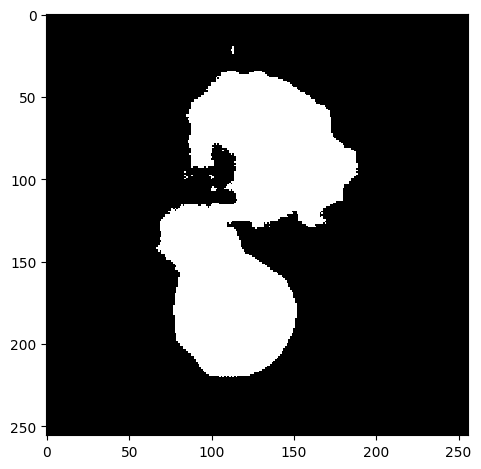

In [52]:
preds_val3 = model3.predict(val_images, verbose=1)

preds_val_t3 = (preds_val3 > 0.5).astype(np.float32)

ix = 8
imshow(val_images[int(val_images.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(val_masks[int(val_masks.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t3[ix]))
plt.show()

In [54]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Calculate Dice coefficient for each sample
dice_scores = []
for i in range(len(val_images)):
    dice = dice_coefficient(val_masks[i], preds_val_t1[i])
    dice_scores.append(dice)

# Calculate the average Dice coefficient
average_dice = np.mean(dice_scores)

print("Average Dice coefficient of first mdoel:", average_dice)

Average Dice coefficient of first mdoel: 0.7255889


In [55]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Calculate Dice coefficient for each sample
dice_scores = []
for i in range(len(val_images)):
    dice = dice_coefficient(val_masks[i], preds_val_t2[i])
    dice_scores.append(dice)

# Calculate the average Dice coefficient
average_dice = np.mean(dice_scores)

print("Average Dice coefficient of second model:", average_dice)

Average Dice coefficient of second model: 0.7131208


In [56]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Calculate Dice coefficient for each sample
dice_scores = []
for i in range(len(val_images)):
    dice = dice_coefficient(val_masks[i], preds_val_t3[i])
    dice_scores.append(dice)

# Calculate the average Dice coefficient
average_dice = np.mean(dice_scores)

print("Average Dice coefficient of second model:", average_dice)

Average Dice coefficient of second model: 0.76597047
